In [146]:
%matplotlib inline
from matplotlib import style
style.use('ggplot')
# print(style.available)
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

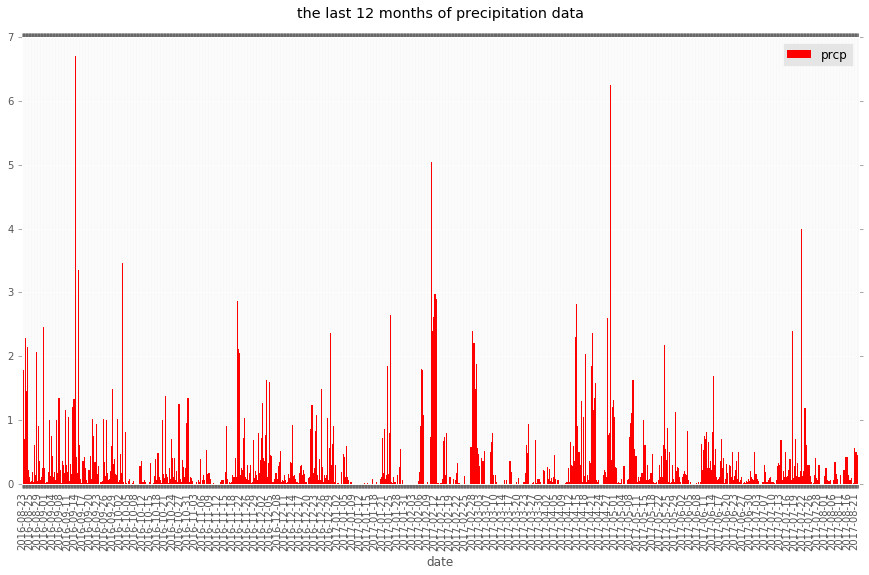

In [150]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores

query = '''
        SELECT m.date,
               m.prcp
        FROM measurement AS m
        WHERE m.date >= date((SELECT MAX(m2.date) AS last_date FROM measurement AS m2), '-1 year')
'''

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql_query(query, engine)
df.set_index('date', inplace=True)

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(1,1, figsize=(15,8))
df.plot.bar(ax=ax, color='red', width=3, edgecolor = "none")
plt.title("the last 12 months of precipitation data", pad=20)


# Reduce the number of xticks for readability
every_nth = 20
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [70]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [74]:
# Design a query to show how many stations are available in this dataset?
query = '''
        SELECT COUNT(DISTINCT m.station) AS "number of station"
         FROM measurement AS m
'''

station_count = pd.read_sql_query(query, engine)
station_count

,number of station
0,9


In [79]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query = '''
        SELECT m.station,
               COUNT(*)
         FROM measurement AS m
         GROUP BY 1
         ORDER BY 2 DESC
'''

active_station = pd.read_sql_query(query, engine)
active_station

,station,COUNT(*)
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [77]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

query = '''
        SELECT MIN(m.tobs) AS "Lowest temperature",
               MAX(m.tobs) AS "Highest temperature",
               AVG(m.tobs) AS "Average temperature"
         FROM measurement AS m
         WHERE m.station = 'USC00519281'         
'''

temperature_most_active_station = pd.read_sql_query(query, engine)
temperature_most_active_station

,Lowest temperature,Highest temperature,Average temperature
0,54.0,85.0,71.663781


station           USC00519281
Number of obs.           2772
Name: 0, dtype: object


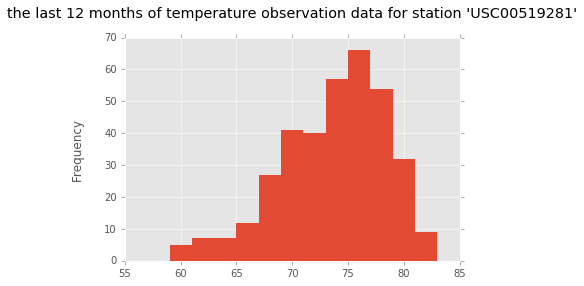

In [149]:
# Choose the station with the highest number of temperature observations.
# Design a query to ask for the number of temperature observations for each station
query = '''
        SELECT m.station,
               COUNT(m.tobs) AS "Number of obs."
         FROM measurement AS m
         GROUP BY 1
         ORDER BY 2 DESC
'''

number_temperature_obs = pd.read_sql_query(query, engine)
print(number_temperature_obs.iloc[0])  # The station 'USC00519281' has the highest number of temperature observations.


# Query the last 12 months of temperature observation data for station 'USC00519281' and plot the results as a histogram
query = '''
        SELECT m.tobs
         FROM measurement AS m
         WHERE (m.date >= date((SELECT MAX(m2.date)
                               FROM measurement AS m2
                               WHERE m2.station = 'USC00519281')
                               , '-1 year'))
         AND (m.station = 'USC00519281')
'''

temperature_most_active_station_1year = pd.read_sql_query(query, engine)
temperature_most_active_station_1year.hist(bins=12, edgecolor = "none")
plt.title("the last 12 months of temperature observation data for station 'USC00519281'", pad=20)
plt.ylabel('Frequency', labelpad=20);

In [105]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [202]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps('2017-08-07', '2017-08-22')) # Tmin, Tavg, and Tmax temperature
Tmin, Tavg, Tmax = np.ravel(calc_temps('2017-08-07', '2017-08-22'))

[(70.0, 78.65079365079364, 85.0)]


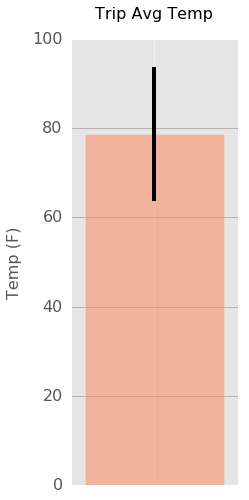

In [203]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=(3,8))

ax.bar(x=0, height=Tavg, width=0.1, yerr=(Tmax-Tmin),
       color='coral', alpha=0.5, tick_label=[""],
       error_kw=dict(ecolor='black', elinewidth=4, capsize=0))

plt.title("Trip Avg Temp", fontsize=16, pad=20)
plt.ylabel("Temp (F)", fontsize=16, labelpad=10)
plt.tick_params(labelsize=16,
                which='both', top=False, left=False, right=False, bottom=False) # Remove all ticks
ax.grid(axis='y', color='grey')

In [205]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

query = '''
        SELECT s.station,
               s.name,
               s.latitude,
               s.longitude,
               s.elevation,
               sq.total_rainfall
         FROM station AS s
         LEFT JOIN (SELECT m.station,
                           SUM(m.prcp) AS total_rainfall
                     FROM measurement AS m
                     WHERE m.date >= date('2017-08-07') AND
                           m.date <= date('2017-08-22')
                     GROUP BY 1 ) AS sq
              ON s.station == sq.station
         ORDER BY 6 DESC
'''

rainfall_per_station_for_mytrip = pd.read_sql_query(query, engine)
rainfall_per_station_for_mytrip

,station,name,latitude,longitude,elevation,total_rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.09
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.51
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.26
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.14
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.02
5,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,NaN
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN
7,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,NaN
8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,NaN


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


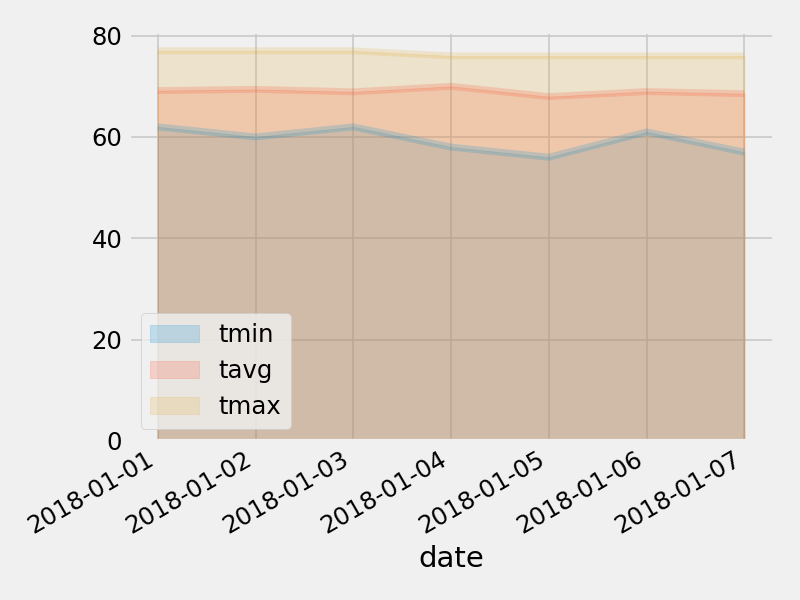

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
